In [1]:
import pandas as pd

# Load dataset
data = pd.read_csv("train_data.csv")

# Melihat struktur dataset
print("Info Dataset:")
print(data.info())

# Statistik Deskriptif
print("\nStatistik Deskriptif:")
print(data.describe())

# 5 Baris Data Teratas
print("\n5 Baris Data Teratas:")
print(data.head())

# Menampilkan jumlah data yang cancel dan non-cancel
print("\nJumlah Data Canceled dan Not Canceled:")
print(data['booking status'].value_counts())



Info Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   number of adults          800 non-null    int64  
 1   number of children        800 non-null    int64  
 2   number of weekend nights  800 non-null    int64  
 3   number of week nights     800 non-null    int64  
 4   type of meal              800 non-null    int64  
 5   car parking space         800 non-null    int64  
 6   room type                 800 non-null    int64  
 7   lead time                 800 non-null    int64  
 8   market segment type       800 non-null    int64  
 9   average price             800 non-null    float64
 10  special requests          800 non-null    int64  
 11  booking status            800 non-null    int64  
dtypes: float64(1), int64(11)
memory usage: 75.1 KB
None

Statistik Deskriptif:
       number of adults  number

### TRAIN TEST SPLIT

In [2]:
import pandas as pd
import numpy as np

# Memuat data latih dan data uji yang sudah dipisahkan
train_data = pd.read_csv("train_data.csv")
test_data = pd.read_csv("test_data.csv")

# Memisahkan fitur dan target
X_train = train_data.drop(['booking status'], axis=1)
y_train = train_data['booking status']
X_test = test_data.drop(['booking status'], axis=1)
y_test = test_data['booking status']

# Ukuran dataset
print("Ukuran Total Dataset (train_data):", train_data.shape)
print("Ukuran Total Dataset (test_data):", test_data.shape)

# Ukuran data train dan test
print("Ukuran Data Train (X_train, y_train):", X_train.shape, y_train.shape)
print("Ukuran Data Test (X_test, y_test):", X_test.shape, y_test.shape)


Ukuran Total Dataset (train_data): (800, 12)
Ukuran Total Dataset (test_data): (200, 12)
Ukuran Data Train (X_train, y_train): (800, 11) (800,)
Ukuran Data Test (X_test, y_test): (200, 11) (200,)


### MODEL RANDOM FORREST

In [12]:
import pandas as pd
import numpy as np

# Load dataset
data = pd.read_csv("dataset_1000.csv")

# Pemetaan target
data['booking status'] = data['booking status'].map({'Canceled': 1, 'Not_Canceled': 0})

# One-Hot Encoding untuk variabel kategorikal
categorical_columns = ['type of meal', 'room type', 'market segment type']
data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

# Memisahkan fitur dan target
X = data.drop(['booking status'], axis=1).values  # Konversi ke NumPy array
y = data['booking status'].values  # Konversi ke NumPy array

# Menggabungkan kembali menjadi dataset untuk kompatibilitas kode
dataset = np.hstack((X, y.reshape(-1, 1))).tolist()  # Gabungkan fitur dan target

# Random Forest Manual
def gini_index(groups, classes):
    n_instances = sum([len(group) for group in groups])
    gini = 0.0
    for group in groups:
        size = len(group)
        if size == 0:
            continue
        score = 0.0
        for class_val in classes:
            proportion = [row[-1] for row in group].count(class_val) / size
            score += proportion * proportion
        gini += (1.0 - score) * (size / n_instances)
    return gini

def test_split(index, value, dataset):
    left, right = list(), list()
    for row in dataset:
        if row[index] < value:
            left.append(row)
        else:
            right.append(row)
    return left, right

def get_split(dataset):
    class_values = list(set(row[-1] for row in dataset))
    best_index, best_value, best_score, best_groups = 999, 999, 999, None
    for index in range(len(dataset[0]) - 1):
        for row in dataset:
            groups = test_split(index, row[index], dataset)
            gini = gini_index(groups, class_values)
            if gini < best_score:
                best_index, best_value, best_score, best_groups = index, row[index], gini, groups
    return {'index': best_index, 'value': best_value, 'groups': best_groups}

def to_terminal(group):
    outcomes = [row[-1] for row in group]
    return max(set(outcomes), key=outcomes.count)

def split(node, max_depth, min_size, depth):
    left, right = node['groups']
    del(node['groups'])
    if not left or not right:
        node['left'] = node['right'] = to_terminal(left + right)
        return
    if depth >= max_depth:
        node['left'], node['right'] = to_terminal(left), to_terminal(right)
        return
    if len(left) <= min_size:
        node['left'] = to_terminal(left)
    else:
        node['left'] = get_split(left)
        split(node['left'], max_depth, min_size, depth + 1)
    if len(right) <= min_size:
        node['right'] = to_terminal(right)
    else:
        node['right'] = get_split(right)
        split(node['right'], max_depth, min_size, depth + 1)

def build_tree(train, max_depth, min_size):
    root = get_split(train)
    split(root, max_depth, min_size, 1)
    return root

def predict(node, row):
    if row[node['index']] < node['value']:
        if isinstance(node['left'], dict):
            return predict(node['left'], row)
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return predict(node['right'], row)
        else:
            return node['right']

def random_forest(train, test, max_depth, min_size, n_trees):
    trees = list()
    for _ in range(n_trees):
        sample_indices = np.random.choice(len(train), len(train), replace=True)
        sample = [train[i] for i in sample_indices]
        tree = build_tree(sample, max_depth, min_size)
        trees.append(tree)
    predictions = [
        max(set([predict(tree, row) for tree in trees]),
            key=[predict(tree, row) for tree in trees].count)
        for row in test
    ]
    return predictions

def evaluate_forest(dataset, max_depth, min_size, n_trees):
    np.random.seed(42)
    shuffled_indices = np.random.permutation(len(dataset))
    train_size = int(0.8 * len(dataset))
    train = [dataset[i] for i in shuffled_indices[:train_size]]
    test = [dataset[i] for i in shuffled_indices[train_size:]]
    predictions = random_forest(train, test, max_depth, min_size, n_trees)
    actual = [row[-1] for row in test]
    accuracy = sum([1 for i in range(len(actual)) if actual[i] == predictions[i]]) / len(actual)
    return accuracy

# Evaluasi Random Forest Manual
max_depth = 10
min_size = 3
n_trees = 40

accuracy = evaluate_forest(dataset, max_depth=max_depth, min_size=min_size, n_trees=n_trees)
parameter = {'max_depth': max_depth, 'min_size': min_size, 'n_trees': n_trees}
print("Parameter:", parameter)
print("Akurasi Random Forest (manual):", accuracy)



Parameter: {'max_depth': 10, 'min_size': 3, 'n_trees': 40}
Akurasi Random Forest (manual): 0.675


In [3]:
import pandas as pd
import numpy as np

# Load train and test datasets
train_data = pd.read_csv("train_data.csv")
test_data = pd.read_csv("test_data.csv")

# Pemetaan target untuk training
train_data['booking status'] = train_data['booking status'].map({1: 1, 0: 0})  # Assuming '1' is 'Canceled' and '0' is 'Not_Canceled'

# Memisahkan fitur dan target untuk training
X_train = train_data.drop(['booking status'], axis=1).values  # Convert to NumPy array
y_train = train_data['booking status'].values  # Convert to NumPy array

# Combine features and target for training
train_dataset = np.hstack((X_train, y_train.reshape(-1, 1))).tolist()  # Combine features and target

# Pemetaan target untuk testing
test_data['booking status'] = test_data['booking status'].map({1: 1, 0: 0})  # Assuming same mapping for test data

# Memisahkan fitur dan target untuk testing
X_test = test_data.drop(['booking status'], axis=1).values  # Convert to NumPy array
y_test = test_data['booking status'].values  # Convert to NumPy array

# Combine features and target for testing
test_dataset = np.hstack((X_test, y_test.reshape(-1, 1))).tolist()  # Combine features and target

# Random Forest Helper Functions
def gini_index(groups, classes):
    n_instances = sum([len(group) for group in groups])
    gini = 0.0
    for group in groups:
        size = len(group)
        if size == 0:
            continue
        score = 0.0
        for class_val in classes:
            proportion = [row[-1] for row in group].count(class_val) / size
            score += proportion * proportion
        gini += (1.0 - score) * (size / n_instances)
    return gini

def test_split(index, value, dataset):
    left, right = list(), list()
    for row in dataset:
        if row[index] < value:
            left.append(row)
        else:
            right.append(row)
    return left, right

def get_split(dataset):
    class_values = list(set(row[-1] for row in dataset))
    best_index, best_value, best_score, best_groups = 999, 999, 999, None
    for index in range(len(dataset[0]) - 1):
        for row in dataset:
            groups = test_split(index, row[index], dataset)
            gini = gini_index(groups, class_values)
            if gini < best_score:
                best_index, best_value, best_score, best_groups = index, row[index], gini, groups
    return {'index': best_index, 'value': best_value, 'groups': best_groups}

def to_terminal(group):
    outcomes = [row[-1] for row in group]
    return max(set(outcomes), key=outcomes.count)

def split(node, max_depth, min_size, depth):
    left, right = node['groups']
    del(node['groups'])
    if not left or not right:
        node['left'] = node['right'] = to_terminal(left + right)
        return
    if depth >= max_depth:
        node['left'], node['right'] = to_terminal(left), to_terminal(right)
        return
    if len(left) <= min_size:
        node['left'] = to_terminal(left)
    else:
        node['left'] = get_split(left)
        split(node['left'], max_depth, min_size, depth + 1)
    if len(right) <= min_size:
        node['right'] = to_terminal(right)
    else:
        node['right'] = get_split(right)
        split(node['right'], max_depth, min_size, depth + 1)

def build_tree(train, max_depth, min_size):
    root = get_split(train)
    split(root, max_depth, min_size, 1)
    return root

def predict(node, row):
    if row[node['index']] < node['value']:
        if isinstance(node['left'], dict):
            return predict(node['left'], row)
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return predict(node['right'], row)
        else:
            return node['right']

def random_forest(train, test, max_depth, min_size, n_trees):
    trees = list()
    for _ in range(n_trees):
        sample_indices = np.random.choice(len(train), len(train), replace=True)
        sample = [train[i] for i in sample_indices]
        tree = build_tree(sample, max_depth, min_size)
        trees.append(tree)
    predictions = [
        max(set([predict(tree, row) for tree in trees]),
            key=[predict(tree, row) for tree in trees].count)
        for row in test
    ]
    return predictions

def evaluate_forest(train_dataset, test_dataset, max_depth, min_size, n_trees):
    predictions = random_forest(train_dataset, test_dataset, max_depth, min_size, n_trees)
    actual = [row[-1] for row in test_dataset]
    accuracy = sum([1 for i in range(len(actual)) if actual[i] == predictions[i]]) / len(actual)
    return accuracy

# Evaluasi Random Forest Manual
max_depth = 10
min_size = 3
n_trees = 40

accuracy = evaluate_forest(train_dataset, test_dataset, max_depth=max_depth, min_size=min_size, n_trees=n_trees)
parameter = {'max_depth': max_depth, 'min_size': min_size, 'n_trees': n_trees}
print("Parameter:", parameter)
print("Akurasi Random Forest (manual):", accuracy)

Parameter: {'max_depth': 10, 'min_size': 3, 'n_trees': 40}
Akurasi Random Forest (manual): 0.795


In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model dengan scikit-learn
model = RandomForestClassifier(n_estimators=40, max_depth=10, random_state=42)
model.fit(X_train, y_train)

# Evaluasi
y_pred = model.predict(X_test)
print("Akurasi sklearn Random Forest:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Akurasi sklearn Random Forest: 0.65
              precision    recall  f1-score   support

           0       0.68      0.68      0.68        22
           1       0.61      0.61      0.61        18

    accuracy                           0.65        40
   macro avg       0.65      0.65      0.65        40
weighted avg       0.65      0.65      0.65        40



In [14]:
from sklearn.model_selection import GridSearchCV

# Definisi grid hyperparameter
param_grid = {
    'n_estimators': [5,10,20,30,40,50],
    'max_depth': [2,3,5, 10,20],
    'min_samples_split': [2,3, 5],
    'min_samples_leaf': [1, 5]
}

# Grid Search untuk mencari parameter terbaik
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Model terbaik
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)



Best Parameters: {'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


### PEMILIHAN FEATURE

In [5]:
pip install matplotlib


   ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.0 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.0 MB ? eta -:--:--
   -- ------------------------------------- 0.5/8.0 MB 558.9 kB/s eta 0:00:14
   -- ------------------------------------- 0.5/8.0 MB 558.9 kB/s eta 0:00:14
   --- ------------------------------------ 0.8/8.0 MB 578.7 kB/s eta 0:00:13
   --- ------------------------------------ 0.8/8.0 MB 578.7 kB/s eta 0:00:13
   --- ------------------------------------ 0.8/8.0 MB 578.7 kB/s eta 0:00:13
   --- ------------------------------------ 0.8/8.0 MB 578.7 kB/s eta 0:00:13
   ----- ---------------------------------- 1.0/8.0 MB 498.4 kB/s eta 0:00:15
   ----- ---------------------------------- 1.0/8.0 MB 498.4 kB/s eta 0:00:15
   ----- ----------------------

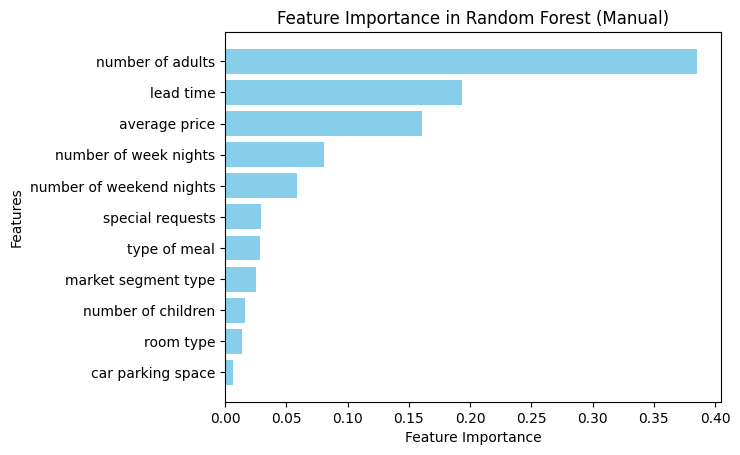

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load train dataset
train_data = pd.read_csv("train_data.csv")

# Pemetaan target
train_data['booking status'] = train_data['booking status'].map({1: 1, 0: 0})

# Memisahkan fitur dan target
X_train = train_data.drop(['booking status'], axis=1).values
y_train = train_data['booking status'].values

# Combine features and target for training
train_dataset = np.hstack((X_train, y_train.reshape(-1, 1))).tolist()

# Random Forest Helper Functions
def gini_index(groups, classes):
    n_instances = sum([len(group) for group in groups])
    gini = 0.0
    for group in groups:
        size = len(group)
        if size == 0:
            continue
        score = 0.0
        for class_val in classes:
            proportion = [row[-1] for row in group].count(class_val) / size
            score += proportion * proportion
        gini += (1.0 - score) * (size / n_instances)
    return gini

def test_split(index, value, dataset):
    left, right = list(), list()
    for row in dataset:
        if row[index] < value:
            left.append(row)
        else:
            right.append(row)
    return left, right

def get_split(dataset):
    class_values = list(set(row[-1] for row in dataset))
    best_index, best_value, best_score, best_groups = 999, 999, 999, None
    for index in range(len(dataset[0]) - 1):
        for row in dataset:
            groups = test_split(index, row[index], dataset)
            gini = gini_index(groups, class_values)
            if gini < best_score:
                best_index, best_value, best_score, best_groups = index, row[index], gini, groups
    return {'index': best_index, 'value': best_value, 'groups': best_groups}

def to_terminal(group):
    outcomes = [row[-1] for row in group]
    return max(set(outcomes), key=outcomes.count)

def split(node, max_depth, min_size, depth):
    left, right = node['groups']
    del(node['groups'])
    if not left or not right:
        node['left'] = node['right'] = to_terminal(left + right)
        return
    if depth >= max_depth:
        node['left'], node['right'] = to_terminal(left), to_terminal(right)
        return
    if len(left) <= min_size:
        node['left'] = to_terminal(left)
    else:
        node['left'] = get_split(left)
        split(node['left'], max_depth, min_size, depth + 1)
    if len(right) <= min_size:
        node['right'] = to_terminal(right)
    else:
        node['right'] = get_split(right)
        split(node['right'], max_depth, min_size, depth + 1)

def build_tree(train, max_depth, min_size):
    root = get_split(train)
    split(root, max_depth, min_size, 1)
    return root

# Fungsi menghitung pentingnya fitur
def calculate_feature_importance(dataset, max_depth, min_size, n_trees):
    feature_count = [0] * (len(dataset[0]) - 1)  # Hitung jumlah fitur
    for _ in range(n_trees):
        sample_indices = np.random.choice(len(dataset), len(dataset), replace=True)  # Ambil sampel dengan bootstrapping
        sample = [dataset[i] for i in sample_indices]
        tree = build_tree(sample, max_depth, min_size)
        
        # Traverse pohon untuk menghitung penggunaan fitur
        def traverse(node):
            if isinstance(node, dict):
                feature_count[node['index']] += 1  # Tingkatkan jumlah penggunaan fitur
                traverse(node.get('left', {}))
                traverse(node.get('right', {}))
        
        traverse(tree)
    
    # Normalisasi pentingnya fitur
    total_splits = sum(feature_count)
    feature_importance = [count / total_splits for count in feature_count]
    return feature_importance

# Parameter
max_depth = 10
min_size = 3
n_trees = 40

# Analisis fitur
feature_importance = calculate_feature_importance(train_dataset, max_depth, min_size, n_trees)

# Menyusun fitur dan kepentingannya
feature_names = train_data.drop(['booking status'], axis=1).columns
feature_importance_sorted = sorted(zip(feature_names, feature_importance), key=lambda x: x[1])

# Visualisasi fitur
sorted_features, sorted_importance = zip(*feature_importance_sorted)
plt.barh(sorted_features, sorted_importance, color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance in Random Forest (Manual)")
plt.show()

### CEK AKURASI

In [16]:
import numpy as np
import pandas as pd

# Fungsi untuk menghitung MSE, RMSE, dan R²
def evaluate_model(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    r2 = 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))
    return mse, rmse, r2

y_pred_discretized = (y_pred > 0.5).astype(int)

# Menghitung MSE, RMSE, dan R² dengan prediksi yang telah diubah
mse = np.mean((y_test - y_pred_discretized) ** 2)
rmse = np.sqrt(mse)
r2 = 1 - (np.sum((y_test - y_pred_discretized) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2))

# Output
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")

# Membandingkan hasil prediksi dengan nilai aktual
comparison = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_discretized
})

print("\nHasil Prediksi vs Nilai Aktual:")
print(comparison.head(20))


Mean Squared Error (MSE): 0.35
Root Mean Squared Error (RMSE): 0.5916079783099616
R² Score: -0.4141414141414139

Hasil Prediksi vs Nilai Aktual:
    Actual  Predicted
0        1          0
1        1          0
2        0          1
3        0          0
4        0          1
5        1          1
6        1          1
7        0          0
8        1          1
9        1          0
10       0          0
11       1          0
12       0          1
13       1          1
14       0          0
15       0          0
16       1          0
17       0          0
18       0          0
19       0          0
